In [14]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from jupyterthemes import jtplot
from MCEq.particlemanager import ParticleManager
import MCEq.core 
from MCEq.core import MCEqRun
from MCEq.data import Decays
import mceq_config as config
#import primary model choices
import crflux.models as pm
# Silincing mceq, set to 1 or higher for output
config.debug_level = 0
# Launcing mceq
mceq_run = MCEqRun(
    #provide the string of the interaction model
    interaction_model='SIBYLL23CPP',
    #primary cosmic ray flux model
    primary_model = (pm.HillasGaisser2012, "H3a"),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0
)


In [15]:
#list of particles in concern
list_particles=[mceq_run.pman[2212],     #p+           (0)
                mceq_run.pman[-2212],     #pbar-        (1)
                mceq_run.pman[2112],     #n            (2)
                mceq_run.pman[-2112],    #nbar         (3)
                mceq_run.pman[211],      #pi+          (4)
                mceq_run.pman[-211],     #pi-          (5)
                mceq_run.pman[310],      #K_S0         (6) 
                mceq_run.pman[130],      #K_L0         (7)
                mceq_run.pman[321],      #K+           (8)
                mceq_run.pman[-321],     #K-           (9)
                mceq_run.pman[111],      #pi0          (10)
                mceq_run.pman[-3122],    #Lambda_r0    (11)
                mceq_run.pman[3122],     #Lambda0      (12)
                mceq_run.pman[(13,0)],   #mu-          (13)
                mceq_run.pman[(-13,0)],  #mu+          (14)
                mceq_run.pman[-11],      #e+           (15)   
                mceq_run.pman[11],       #e-           (16)
          

                mceq_run.pman[14],       #nue          (21)
                mceq_run.pman[-14],      #nuebar       (22)
                mceq_run.pman[12],       #numu         (23)
                mceq_run.pman[-12],      #numubar      (24) 
                mceq_run.pman[22]#gamma        (25)
               ]

In [16]:
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
#list of pdg ids 
list_particles_pdg_id=[]
for i in range(0,len(list_particles)):
    list_particles_pdg_id.append(list_particles[i].pdg_id)

In [36]:
len(list_particles)*121
from scipy.sparse import *

In [18]:
import pickle
#with open('/home/kruteesh/Desktop/Solar_neutrinos/energyloss.pickle', 'rb') as f:
p_leptons = pickle.load(open('/home/kruteesh/Desktop/Solar_neutrinos/Energy_loss_1.pkl','rb'))
#And the rate matrices:


In [19]:
p_leptons.keys()

dict_keys(['egrid', 'ebin', 'ewidth', '(11,22)', '(11,11)', '(11,13)', '(11,-13)', '(-11,22)', '(-11,-11)', '(-11,13)', '(-11,-13)', '(22,11)', '(22,-11)', '(22,22)', '(22,13)', '(22,-13)', '(13,22)', '(13,13)', '(-13,22)', '(-13,-13)', 'xsec 11', 'totIntLength 11', 'xsec -11', 'totIntLength -11', 'xsec 22', 'totIntLength 22', 'xsec 13', 'totIntLength 13', 'xsec -13', 'totIntLength -13', 'dEdX 11', 'dEdX -11', 'dEdX 13', 'dEdX -13', 'ion', 'equation'])

In [69]:


class interactions:
    def __init__(self,particles,particles_pdg_id):
        self.particles=particles
        self.particles_pdg_id=particles_pdg_id
        self.p_loss_dict= pickle.load(open('/home/kruteesh/Desktop/Solar_neutrinos/Energy_loss_1.pkl','rb'))

        self.emca_child=np.array([
             mceq_run.pman[(13,0)],   #mu-          (13)
                mceq_run.pman[(-13,0)],  #mu+          (14)
                mceq_run.pman[-11],      #e+           (15)   
                mceq_run.pman[11],  
            mceq_run.pman[22]#e-           (16)
            ])
        self.emca_parent=np.array([
             mceq_run.pman[(13,0)],   #mu-          (13)
                mceq_run.pman[(-13,0)], #mu+          (14)
                mceq_run.pman[-11],      #e+           (15)   
                mceq_run.pman[11],  
            mceq_run.pman[22]
        ])
        
        
        
        
    def E_loss_sec_par(self):
        """""
        A dictionary containing  the secondary particles wise yields of list_particles with losses
        """""

        p_lep={}
        for child in self.emca_child:
            p_lep[child.name,'ds']=np.empty((len(mceq_run.e_grid),len(mceq_run.e_grid)))
            p_lep[child.name,'dn']=np.empty((len(mceq_run.e_grid),len(mceq_run.e_grid)))
            
            for i, parent in enumerate(self.particles):
                if i==0:
                    if child in parent.hadr_secondaries:
                            
                            p_lep[child.name,'ds']=parent.hadr_yields[child]*parent.inel_cross_section(mbarn=False)/ mceq_run.e_widths /np.pi
                            p_lep[child.name,'dn']=parent.hadr_yields[child]/ mceq_run.e_widths /np.pi
                            
                    else:
                            p_lep[child.name,'ds']=np.zeros((len(mceq_run.e_grid),len(mceq_run.e_grid)))
                            p_lep[child.name,'dn']=np.zeros((len(mceq_run.e_grid),len(mceq_run.e_grid)))
                             
                else:
                    if parent in self.emca_parent:

                        s=str('('+str(child.pdg_id[0])+','+str(parent.pdg_id[0])+')')  
                        if s in self.p_loss_dict.keys(): 
                            #print(p_lep[child.name,"ds"].shape,s)
                            p_lep[child.name,'ds']=np.concatenate((p_lep[child.name,'ds'],(np.nan_to_num(self.p_loss_dict[s])
                                                                  *self.p_loss_dict['xsec '+str(child.pdg_id[0])]/mceq_run.e_widths/np.pi )),axis=1)
                            p_lep[child.name,'dn']=np.concatenate((p_lep[child.name,'dn'],(np.nan_to_num(self.p_loss_dict[s])
                                                                  /mceq_run.e_widths/np.pi )),axis=1)

                            
                            #print(p_lep[child.name,"ds"].shape)
                        else:
                            p_lep[child.name,'ds']=np.concatenate((p_lep[child.name,'ds'],np.zeros((len(mceq_run.e_grid),len(mceq_run.e_grid)))),axis=1)
                            p_lep[child.name,'dn']=np.concatenate((p_lep[child.name,'dn'],np.zeros((len(mceq_run.e_grid),len(mceq_run.e_grid)))),axis=1)
                            
                    else:
                        if child in parent.hadr_secondaries:

                            p_lep[child.name,'ds']=np.concatenate((p_lep[child.name,'ds'],parent.hadr_yields[child]*parent.inel_cross_section(mbarn=False) /mceq_run.e_widths / np.pi),axis=1)
                            p_lep[child.name,'dn']=np.concatenate((p_lep[child.name,'dn'],parent.hadr_yields[child]/mceq_run.e_widths / np.pi),axis=1)
                            
                        else:
                            p_lep[child.name,'ds']=np.concatenate((p_lep[child.name,'ds'],np.zeros((len(mceq_run.e_grid),len(mceq_run.e_grid)))),axis=1)
                            p_lep[child.name,'dn']=np.concatenate((p_lep[child.name,'dn'],np.zeros((len(mceq_run.e_grid),len(mceq_run.e_grid)))),axis=1)
                            
            
            p_lep[child.name,'rescale']=self.p_loss_dict['xsec '+str(child.pdg_id[0])]/np.sum(p_lep[child.name,'ds'].T*mceq_run.e_widths,axis=0)


           
        return p_lep


        
        
        
        
        
        
        
    def resclaing_factors(self):
        """ corrects the differential xsec to correspond to the total

        Parameters
        ----------
        particles : list
            List of the particles of interest

        Returns
        -------
        rescale : dic
            Dictionary of rescaling factors for each type
        """
    
        rescale = {}
        for particle in self.particles:
            if particle not in self.emca_child:
                all_dxsec_tmp = np.array(np.nan_to_num([
                    particle.hadr_yields[child] *
                    particle.inel_cross_section(mbarn=False) /  mceq_run.e_widths / np.pi
                    for child in particle.hadr_secondaries
                ]))
                all_xsec_tmp = np.array([
                        np.sum(dxsec.T * mceq_run.e_widths, axis=1)
                        for dxsec in all_dxsec_tmp
                    ])
                #print(np.sum(all_xsec_tmp.T*mceq_run.e_widths, axis=0))
                total_xsec_tmp = np.sum(all_xsec_tmp, axis=0)
               
                rescaling = np.nan_to_num(particle.inel_cross_section(mbarn=False) / total_xsec_tmp)
                rescale[particle.name] = rescaling
            else:
                rescale[particle.name]=self.E_loss_sec_par()[particle.name,'rescale']
        return rescale    
    def store_data(self):
        """
        check the dimensions

        Parameters
        ----------
        particles : list
            List of the particles of interest

        Returns
        -------
        Matrix 
        """
        rescale = self.resclaing_factors()
        final={}     
        for particle in self.particles:
                if particle not in self.emca_child:
                    Data=np.empty((121,121))
                    i=0
                    for parent_particle in self.particles:
                        if particle in parent_particle.hadr_secondaries:
                            if i==0:
                                Data=np.nan_to_num(parent_particle.hadr_yields[particle]  /mceq_run.e_widths / np.pi * rescale[parent_particle.name])
                                i=1
                            else:
                                Data=np.concatenate((Data,parent_particle.hadr_yields[particle] /mceq_run.e_widths / np.pi * rescale[parent_particle.name]),axis=1)
                        else:
                            if i!=0:
                                Data=np.concatenate((Data,np.zeros((len(mceq_run.e_grid), len(mceq_run.e_grid)))),axis=1)
                            else:
                                Data=np.zeros((len(mceq_run.e_grid), len(mceq_run.e_grid)))
                                i=1


                    final[particle.name]=Data
                    
                    
                else:
                   rescale_lep=np.array([])
                   for i in range(0,len(self.particles)):
                        rescale_lep=np.append(rescale_lep,self.E_loss_sec_par()[particle.name,'rescale'])
                    
                   final[particle.name]=self.E_loss_sec_par()[particle.name,'dn']*rescale_lep
        Matrix=np.empty((121,121))
        i=0
        for p in final.keys():
               

                if i==0:
                    Matrix=final[p]
                    i=1
                else:
                
                    Matrix=np.concatenate((Matrix,final[p]),axis=0)
        return csr_matrix(Matrix)     
            
            #pickle.dump(Data,open('../data/Data'+str(particle.name)+'.pkl', "wb" ))

In [70]:
D=interactions(list_particles,list_particles_pdg_id).store_data()

<ipython-input-69-18fa1893b74b>:117: RuntimeWarning: divide by zero encountered in true_divide
  rescaling = np.nan_to_num(particle.inel_cross_section(mbarn=False) / total_xsec_tmp)
<ipython-input-69-18fa1893b74b>:117: RuntimeWarning: invalid value encountered in true_divide
  rescaling = np.nan_to_num(particle.inel_cross_section(mbarn=False) / total_xsec_tmp)


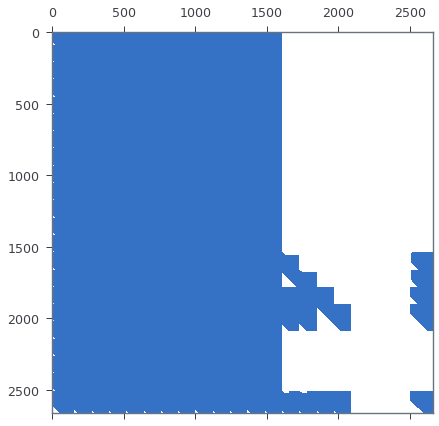

In [76]:
plt.spy(D)

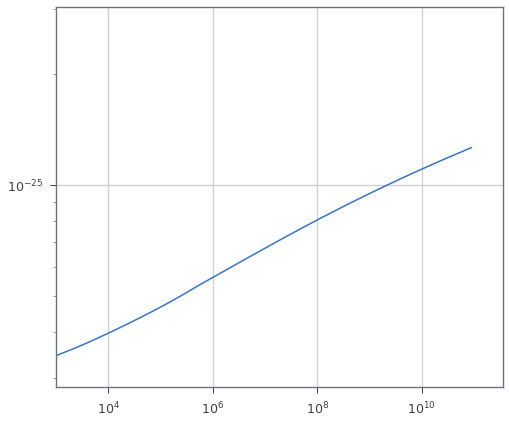

In [27]:
plt.loglog(mceq_run.e_grid,mceq_run.pman[2212].cs)
plt.xlim(1e3,)
plt.grid()

In [10]:
E_loss_par=np.array([
             mceq_run.pman[(13,0)],   #mu-          (13)
                mceq_run.pman[(-13,0)],  #mu+          (14)
                mceq_run.pman[-11],      #e+           (15)   
                mceq_run.pman[11],       #e-           (16)
                mceq_run.pman[22]
])


In [11]:
j=0
ind={}
for i in list_particles:
    ind[i.name,'up']=0+j
    ind[i.name,'low']=121+j
    j=j+122

In [12]:
np.zeros(((len(list_particles)+1)*len(mceq_run.e_grid),(len(list_particles)+1)*len(mceq_run.e_grid)))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
p_lep={}
s=[]
for p in E_loss_par:
    
    p_lep[p.name,'ds']=np.zeros((len(mceq_run.e_grid),len(mceq_run.e_grid)))
    for q in E_loss_par:
        string=str('('+str(p.pdg_id[0])+','+str(q.pdg_id[0])+')')
        if string in s:
            continue
        else:
                s.append(string)

In [14]:
for ss in s:
    if ss in particles.keys():
        print(ss)

NameError: name 'particles' is not defined

In [ ]:
x=E_loss_sec_par(E_loss_par,list_particles,particles)

In [ ]:
(x['e-','ds'].shape)

In [ ]:
np.sum(x.T*mceq_run.e_grid,axis=0).shape

In [ ]:
    p_lep[loss[0].name,'ds']=np.concatenate(p_lep[loss[0].name,'ds'],np.nan_to_num(particles['(13,13)']),axis=0)
    p_lep[loss[0].name,'ds']=np.concatenate(p_lep[loss[0].name,'ds'],np.nan_to_num(particles['(22,13)']),axis=0)
    p_lep[loss[0].name,'ds'][ind[mceq_run.pman[13].name,'up']:ind[mceq_run.pman[13].name,'low']]=np.nan_to_num(particles['(13,13)'])
    p_lep[loss[0].name,'ds'][ind[mceq_run.pman[22].name,'up']:ind[mceq_run.pman[22].name,'low']]=np.nan_to_num(particles['(22,13)'])

    p_lep[loss[0].name,'s']=particles['xsec 13']

    p_lep[loss[1].name,'ds']=np.concatenate(p_lep[loss[1].name,'ds'],particles['(22,-13)'],axis=0)
    p_lep[loss[1].name,'ds']=np.concatenate(p_lep[loss[1].name,'ds'],particles['(-13,-13)'],axis=0)
    
    p_lep[loss[1].name,'ds'][ind[mceq_run.pman[-13].name,'up']:ind[mceq_run.pman[-13].name,'low']]=np.nan_to_num(particles['(-13,-13)'])
    p_lep[loss[1].name,'ds'][ind[mceq_run.pman[11].name,'up']:ind[mceq_run.pman[11].name,'low']]=np.nan_to_num(particles['(11,-13)'])
    p_lep[loss[1].name,'s']=particles['xsec -13']

    p_lep[loss[2].name,'ds'][ind[mceq_run.pman[22].name,'up']:ind[mceq_run.pman[22].name,'low']]=np.nan_to_num(particles['(22,-11'])
    p_lep[loss[2].name,'ds'][ind[mceq_run.pman[-11].name,'up']:ind[mceq_run.pman[-11].name,'low']]=np.nan_to_num(particles['(-11,-11)'])
    p_lep[loss[2].name,'s']=particles['xsec -11']

    p_lep[loss[3].name,'ds'][ind[mceq_run.pman[22].name,'up']:ind[mceq_run.pman[22].name,'low']]=np.nan_to_num(particles['(22,11)'])
    p_lep[loss[3].name,'ds'][ind[mceq_run.pman[11].name,'up']:ind[mceq_run.pman[11].name,'low']]=np.nan_to_num(particles['(11,11)'])
    p_lep[loss[3].name,'s']=particles['xsec 11']

    p_lep[loss[4].name,'ds'][ind[mceq_run.pman[22].name,'up']:ind[mceq_run.pman[22].name,'low']]=np.nan_to_num(particles['(22,22)'])
    p_lep[loss[4].name,'ds'][ind[mceq_run.pman[13].name,'up']:ind[mceq_run.pman[13].name,'low']]=np.nan_to_num(particles['(13,22)'])
    p_lep[loss[4].name,'ds'][ind[mceq_run.pman[11].name,'up']:ind[mceq_run.pman[11].name,'low']]=np.nan_to_num(particles['(11,22)'])
    p_lep[loss[4].name,'s']=particles['xsec 22']


In [ ]:
aa=particles['(-13,-13)']-particles['(13,13)']
if aa.any()!=0:
    print('nope')
else:
    print('alright')

In [ ]:
plt.spy(Matrix)